# Analyzing the Gender Gap in Hollywood

# 0.0 NoteBook Objective

The objective of this notebook is to perform a detailed Exploratort Data Analysis alongside Unsupervised and Supervised Learning Models. for the supervised model, we would utilize Logistic Regression Classifer because of it's intepretability and for Supervised Learning, and for Unsupervised learning, we would utilize LDA (Latent Dirichlet Allocation).

# 1.0 Importing Libraries

In [1]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd
import warnings
import missingno
from tqdm import tqdm

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection, tree, preprocessing, metrics, linear_model, svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, classification_report, plot_confusion_matrix
from catboost import cv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier, plot_importance
import scipy as sp

# Natural Langauge and Word Processing
import re
import nltk
from nltk.tag.stanford import StanfordNERTagger
from nameparser.parser import HumanName
from nltk.corpus import wordnet
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.corpus import wordnet
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
import spacy
nlp = spacy.load("en_core_web_sm") # Load English tokenizer, tagger, parser and NER

In [2]:
import pickle 
import pyLDAvis
import os
import pyLDAvis.gensim_models

In [3]:
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
tqdm.pandas()

# 2.0 Importing DataFrames

### 2.1 Import Cleaned DataFrame from [03_Merging_DataSets] NoteBook

In [5]:
# Import Cleaned Up DataFrame
start = time.time()
warnings.filterwarnings("ignore")
df_final = pd.read_csv('/Users/macbook/Google Drive/0. Ofilispeaks Business (Mac and Cloud)/9. Data Science/0. Python/General Assembly Training/Project 6/data/for_EDA.csv')
end = time.time()
print(f'It took {round((end-start),2)} seconds')

It took 0.44 seconds


In [6]:
df_final.head(1)

,imdb_title_id,original_title_x,imdb_name_id,name_x,height,date_of_birth,place_of_birth,spouses,divorces,children,...,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,ordering,category,role,age_at_release
0,tt0025164,The Gay Divorcee,nm0000001,Fred Astaire,177.0,1899.0,"Omaha, Nebraska, USA",2,0,2,...,520000.0,NaN,6750.0,80.0,61.0,42.0,1,actor,Guy Holden,35.0


### 2.2 Performing some light additional cleaning and processing

In [7]:
df_final['roi'] = df_final['worlwide_gross_income']/df_final['budget'] # Create column for ROI

In [8]:
df_final['year_date'] = pd.to_datetime(df_final['year'], format='%Y') # Create YEAR column

In [9]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### 2.3 Check for Missing Values

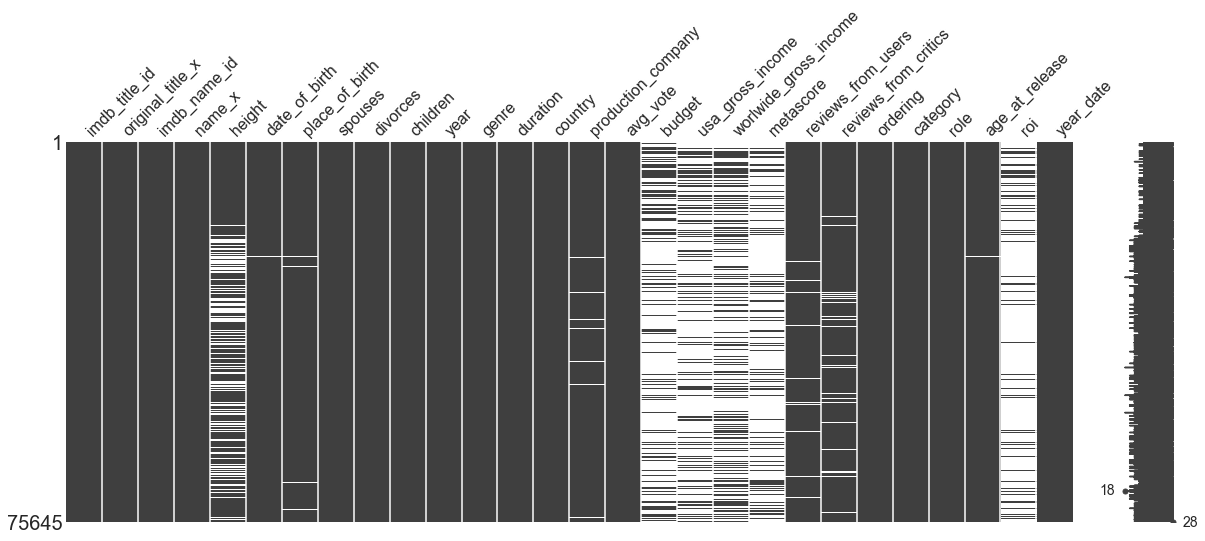

In [10]:
# Showing values with more than 1% of data missing
missingno.matrix(df_final, figsize = (20,7))#, filter='bottom',n=20, p=0.999, sort='ascending');

In [11]:
df_final.columns

Index(['imdb_title_id', 'original_title_x', 'imdb_name_id', 'name_x', 'height',
       'date_of_birth', 'place_of_birth', 'spouses', 'divorces', 'children',
       'year', 'genre', 'duration', 'country', 'production_company',
       'avg_vote', 'budget', 'usa_gross_income', 'worlwide_gross_income',
       'metascore', 'reviews_from_users', 'reviews_from_critics', 'ordering',
       'category', 'role', 'age_at_release', 'roi', 'year_date'],
      dtype='object')

### 2.4 Drop Rows where role is NaN

In [12]:
df_final = df_final.dropna(subset=['role']) # Drop NaN rows in the Role Column

### 2.5 Create Primary DataSet of Movies Made After 1980 and in USA

In [13]:
# Create DataSet of movies released between 1980 and 2019 in the USA
df = df_final[df_final['country'].str.contains('USA', na=False) & (df_final['year']>=1980)& (df_final['year']<2020) & ((df_final['category']=='actress')| (df_final['category']=='actor'))]

In [14]:
# Reset Index
df.reset_index(inplace = True, drop = True)

In [15]:
df.head()

,imdb_title_id,original_title_x,imdb_name_id,name_x,height,date_of_birth,place_of_birth,spouses,divorces,children,...,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,ordering,category,role,age_at_release,roi,year_date
0,tt0095665,Mr. North,nm0000002,Lauren Bacall,174.00000,1924.00000,"The Bronx, New York City, New York, USA",2,1,3,...,1221366.00000,NaN,18.00000,8.00000,3,actress,Amelia Cranston,64.00000,NaN,1988-01-01
1,tt0167423,Diamonds,nm0000002,Lauren Bacall,174.00000,1924.00000,"The Bronx, New York City, New York, USA",2,1,3,...,88428.00000,33.00000,22.00000,30.00000,2,actress,Sin-Dee,75.00000,NaN,1999-01-01
2,tt0783608,The Walker,nm0000002,Lauren Bacall,174.00000,1924.00000,"The Bronx, New York City, New York, USA",2,1,3,...,590416.00000,51.00000,58.00000,72.00000,3,actress,Natalie Van Miter,83.00000,0.05904,2007-01-01
3,tt1368858,The Forger,nm0000002,Lauren Bacall,174.00000,1924.00000,"The Bronx, New York City, New York, USA",2,1,3,...,NaN,NaN,22.00000,8.00000,1,actress,Anne-Marie Cole,88.00000,NaN,2012-01-01
4,tt0080754,The Formula,nm0000008,Marlon Brando,175.00000,1924.00000,"Omaha, Nebraska, USA",3,3,5,...,8894289.00000,NaN,33.00000,17.00000,2,actor,Adam Steiffel,56.00000,0.67381,1980-01-01


### 2.6 Remove Names in Roles to Ensure we extract Key Text

#### Function to Strip Names using NLTK and SPACY to get 2 layers of Name Filters

In [16]:
def strip_names(strings):
    
    # Remove all punctuations
    strings = strings.translate(str.maketrans('', '', string.punctuation))

    # NLTK cleanse
    Sentences = nltk.sent_tokenize(strings)
    Tokens = []

    for Sent in Sentences:
        Tokens.append(nltk.word_tokenize(Sent)) 
        Words_List = [nltk.pos_tag(Token) for Token in Tokens]

    Nouns_List = []

    for List in Words_List:
        for Word in List:
            if re.match('[NN.*]', Word[1]):
                 Nouns_List.append(Word[0])

    Names = []
    for Nouns in Nouns_List:
        if not wordnet.synsets(Nouns):
            Names.append(Nouns)

    # Spacy.IO Cleanse
    empty = []
    doc = nlp(strings)
    for entity in doc.ents:
        if entity.label_ == 'PERSON':
            empty.append(entity.text)

    return list(set(' '.join(empty+Names).split()))

In [17]:
df['stopwords'] = df['role'].progress_apply(strip_names)

100%|██████████| 21250/21250 [02:50<00:00, 124.88it/s]


#### Assign Scraped names as Stop Words into a Singular List

In [18]:
string = []
for i,j in df.iterrows():
    string.extend(j['stopwords'])

#### Create a List of Stop Words and Manually Add New Stop Words

In [19]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['Father','Mr','Man', 'Brother', 'Film','Son','Role','Husband',
                'Character','Role','Mary','Aunt','Grace','Actress','Emily','Films',
                'Woman','Girl','Sister','Daughter','Wife','Mother','Mrs','John']
stopwords.extend(newStopWords)
stopwords.extend(string)
stopwords.extend([x.lower() for x in newStopWords])
stopwords.extend([x.lower() for x in string])

In [20]:
len(stopwords)

71951

# 3.0 Data Analysis Non-Visual

#### Number of Unique Movies

In [21]:
df.imdb_title_id.nunique()

6606

#### Total Number of Actors and Actressess in our DataSet

In [22]:
df['category'].value_counts()

actor      13231
actress     8019
Name: category, dtype: int64

#### Total Number of Actors and Actressess playing lead roles in our DataSet

In [23]:
df[df['ordering']==1]['category'].value_counts()

actor      4052
actress    1756
Name: category, dtype: int64

#### Average Number of Children of Actors and Actresses

In [24]:
df.groupby('category')['children'].mean()

category
actor     1.45356
actress   0.84212
Name: children, dtype: float64

#### Average Budget of Movies Featuring Female and Male Lead

In [25]:
df[df['ordering']==1].groupby('category')['budget'].mean()

category
actor     30638602.44661
actress   19687950.70551
Name: budget, dtype: float64

#### Average Return on Investment of Movies Featuring Female and Male Lead

In [26]:
df[df['ordering']==1].groupby('category')['worlwide_gross_income'].mean()

category
actor     71308803.50018
actress   39803303.71442
Name: worlwide_gross_income, dtype: float64

#### Average Age of Female and Male Lead Actors

In [27]:
df[df['ordering']==1].groupby('category')['age_at_release'].mean().reset_index()

,category,age_at_release
0,actor,41.10524
1,actress,34.63497


#### Average MetaScore of Female and Male Lead Actors

In [28]:
df[df['ordering']==1].groupby('category')['metascore'].mean().reset_index()

,category,metascore
0,actor,49.95130
1,actress,50.19227


# 4.0 Visual Exploratory Data Analysis

#### Create DataFrame Showing Percentage of Movies Actor and Actress Lead Play in a Given Year

In [29]:
df2 = df[(df['ordering']==1)].groupby(['category','year'])['year_date'].size().reset_index(name='prod_count')
a = df2.groupby('year')['prod_count'].transform('sum')
df2['prod_count'] = df2['prod_count'].div(a)*100

# Reference https://stackoverflow.com/questions/49105734/pandas-get-normalize-values-from-groupby-and-size

In [30]:
df2.head(1)

,category,year,prod_count
0,actor,1980,80.00000


#### Graphically Show Actor and Actress Lead Role Representation Across the Years

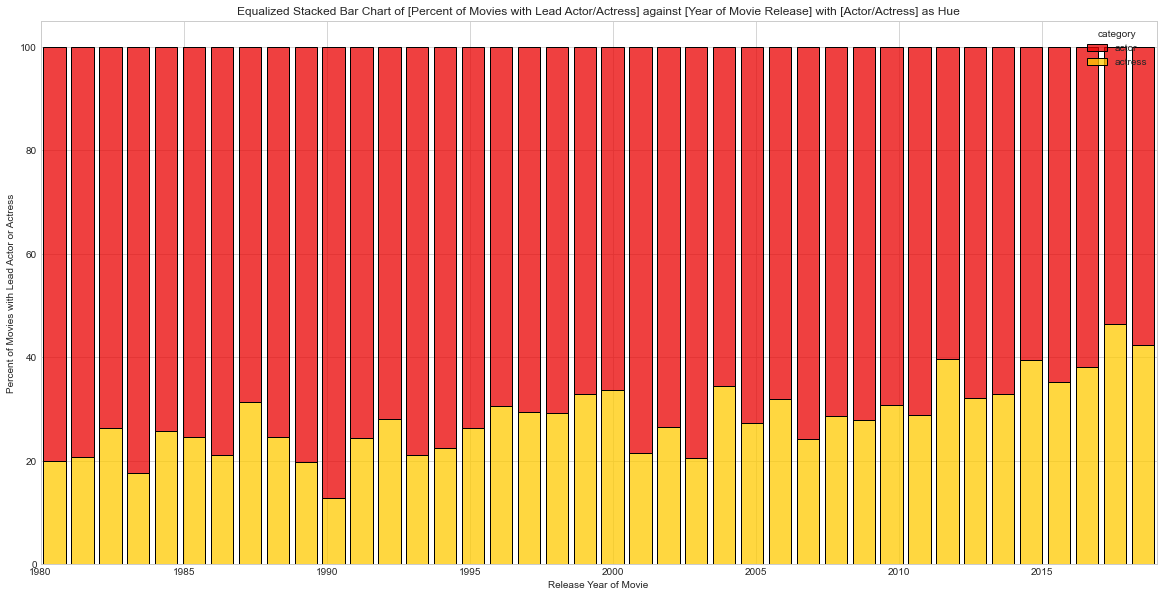

In [31]:
plt.figure(figsize=(20,10))
plt.gca().set(xlim =(1980,2019))
ax = sns.histplot(df2, x='year', hue='category', weights='prod_count', stat = 'count',
             multiple='stack', palette='hot', shrink=0.8, bins = 40,  legend="reverse");
ax.set(xlabel='Release Year of Movie', ylabel='Percent of Movies with Lead Actor or Actress', title='Equalized Stacked Bar Chart of [Percent of Movies with Lead Actor/Actress] against [Year of Movie Release] with [Actor/Actress] as Hue');

#### Graphically Show Actor and Actress Lead Role Representation Across the Years with Genres as Hue

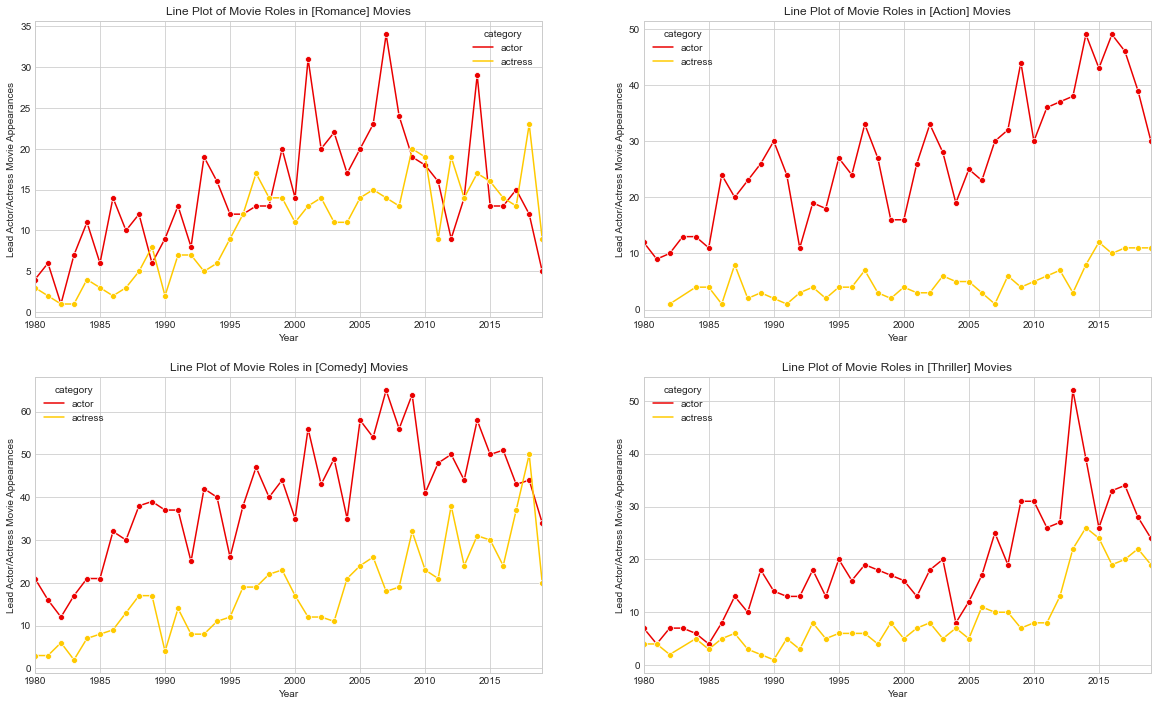

In [32]:
# Code
f, axes = plt.subplots(2, 2, figsize=(20,12))

sns.lineplot(data = df[(df['ordering']==1) & (df['genre'].str.contains('romance',case=False, na=False))].groupby(['category','year'])['year_date'].agg('count').reset_index(), x = 'year', y='year_date', hue ='category',ax=axes[0,0], palette = "hot", dashes = False, marker = "o", legend="brief");
sns.lineplot(data = df[(df['ordering']==1) & (df['genre'].str.contains('comedy',case=False, na=False))].groupby(['category','year'])['year_date'].agg('count').reset_index(), x = 'year', y='year_date', hue ='category',ax=axes[1,0], palette = "hot", dashes = False, marker = "o", legend="brief");
sns.lineplot(data = df[(df['ordering']==1) & (df['genre'].str.contains('action',case=False, na=False))].groupby(['category','year'])['year_date'].agg('count').reset_index(), x = 'year', y='year_date', hue ='category',ax=axes[0,1], palette = "hot", dashes = False, marker = "o", legend="brief");
sns.lineplot(data = df[(df['ordering']==1) & (df['genre'].str.contains('thriller',case=False, na=False))].groupby(['category','year'])['year_date'].agg('count').reset_index(), x = 'year', y='year_date', hue ='category',ax=axes[1,1], palette = "hot", dashes = False, marker = "o", legend="brief");

axes[0, 0].set_title("Line Plot of Movie Roles in [Romance] Movies");
axes[1, 0].set_title("Line Plot of Movie Roles in [Comedy] Movies");
axes[0, 1].set_title("Line Plot of Movie Roles in [Action] Movies");
axes[1, 1].set_title("Line Plot of Movie Roles in [Thriller] Movies");

axes[0, 0].set(xlabel="Year", ylabel="Lead Actor/Actress Movie Appearances",xlim =(1980,2019));
axes[1, 0].set(xlabel="Year", ylabel="Lead Actor/Actress Movie Appearances",xlim =(1980,2019));
axes[0, 1].set(xlabel="Year", ylabel="Lead Actor/Actress Movie Appearances",xlim =(1980,2019));
axes[1, 1].set(xlabel="Year", ylabel="Lead Actor/Actress Movie Appearances",xlim =(1980,2019));

#### Graphically Show Actor and Actress Lead Role Representation Across the Years with Genres as Hue

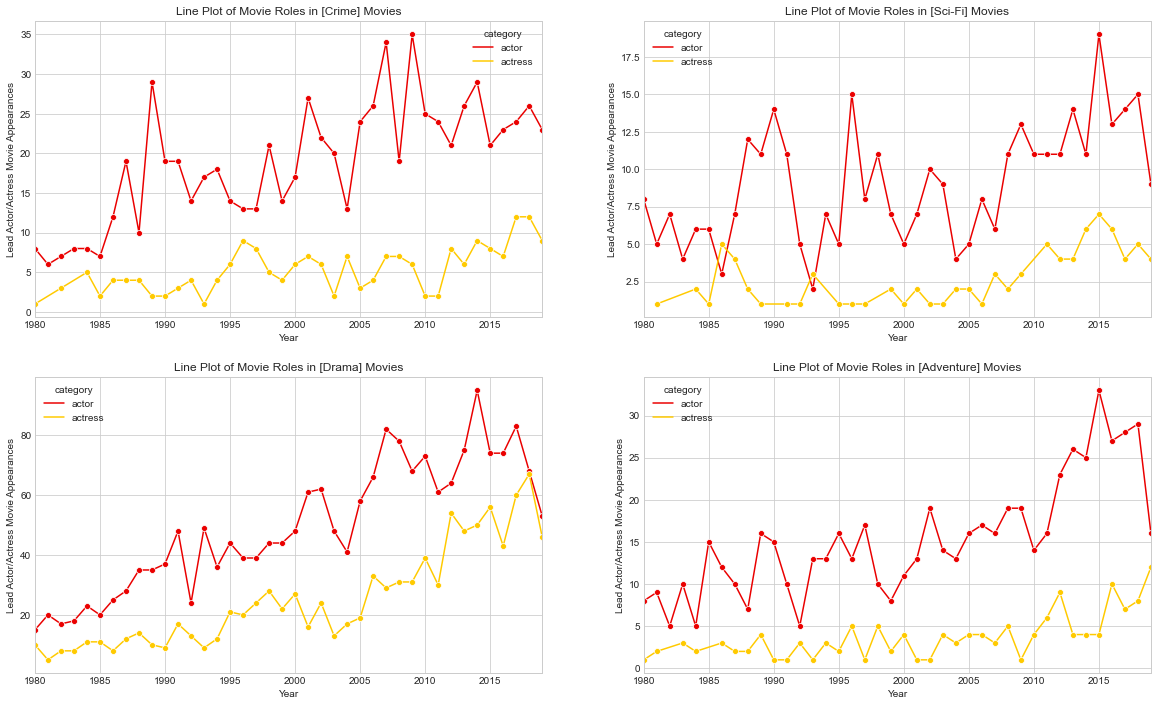

In [33]:
# Code
f, axes = plt.subplots(2, 2, figsize=(20,12))

sns.lineplot(data = df[(df['ordering']==1) & (df['genre'].str.contains('crime',case=False, na=False))].groupby(['category','year'])['year_date'].agg('count').reset_index(), x = 'year', y='year_date', hue ='category',ax=axes[0,0], palette = "hot", dashes = False, marker = "o", legend="brief");
sns.lineplot(data = df[(df['ordering']==1) & (df['genre'].str.contains('drama',case=False, na=False))].groupby(['category','year'])['year_date'].agg('count').reset_index(), x = 'year', y='year_date', hue ='category',ax=axes[1,0], palette = "hot", dashes = False, marker = "o", legend="brief");
sns.lineplot(data = df[(df['ordering']==1) & (df['genre'].str.contains('sci-fi',case=False, na=False))].groupby(['category','year'])['year_date'].agg('count').reset_index(), x = 'year', y='year_date', hue ='category',ax=axes[0,1], palette = "hot", dashes = False, marker = "o", legend="brief");
sns.lineplot(data = df[(df['ordering']==1) & (df['genre'].str.contains('adventure',case=False, na=False))].groupby(['category','year'])['year_date'].agg('count').reset_index(), x = 'year', y='year_date', hue ='category',ax=axes[1,1], palette = "hot", dashes = False, marker = "o", legend="brief");

axes[0, 0].set_title("Line Plot of Movie Roles in [Crime] Movies");
axes[1, 0].set_title("Line Plot of Movie Roles in [Drama] Movies");
axes[0, 1].set_title("Line Plot of Movie Roles in [Sci-Fi] Movies");
axes[1, 1].set_title("Line Plot of Movie Roles in [Adventure] Movies");

axes[0, 0].set(xlabel="Year", ylabel="Lead Actor/Actress Movie Appearances",xlim =(1980,2019));
axes[1, 0].set(xlabel="Year", ylabel="Lead Actor/Actress Movie Appearances",xlim =(1980,2019));
axes[0, 1].set(xlabel="Year", ylabel="Lead Actor/Actress Movie Appearances",xlim =(1980,2019));
axes[1, 1].set(xlabel="Year", ylabel="Lead Actor/Actress Movie Appearances",xlim =(1980,2019));

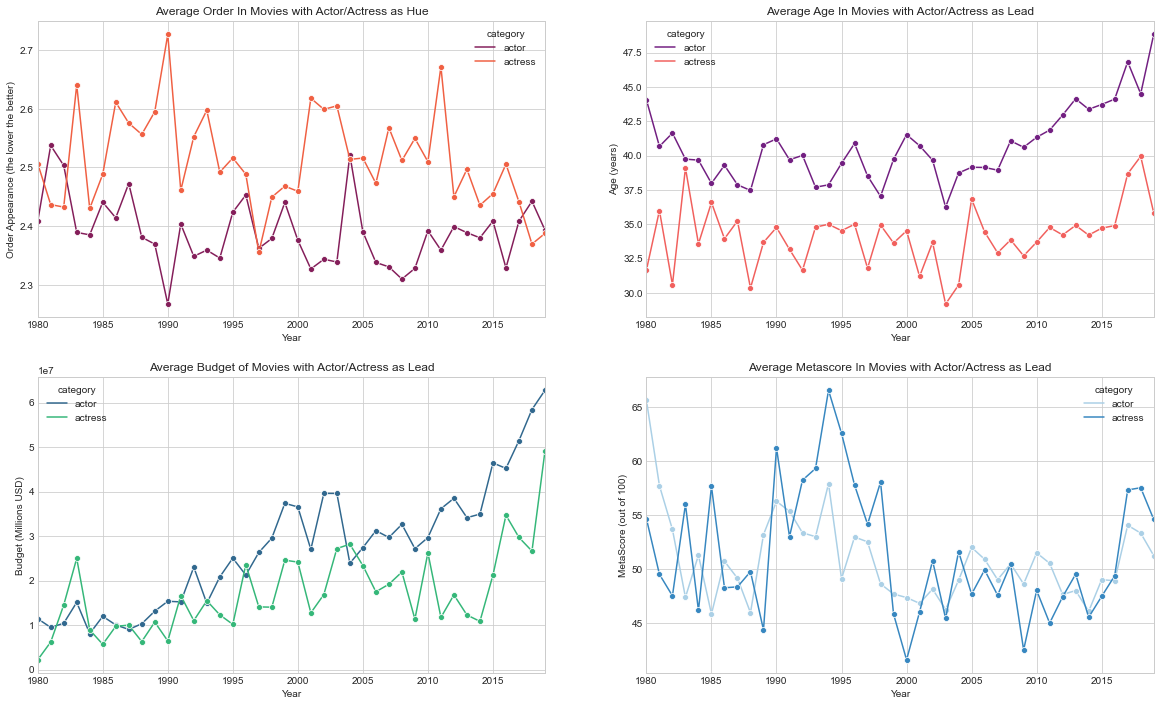

In [34]:
# Code
f, axes = plt.subplots(2, 2, figsize=(20,12))

sns.lineplot(data = df.groupby(['category','year'])['ordering'].agg('mean').reset_index(), x = 'year', y='ordering', hue ='category',ax=axes[0,0], palette = "rocket", dashes = False, marker = "o", legend="brief");
sns.lineplot(data = df[(df['ordering']==1)].groupby(['category','year'])['budget'].agg('mean').reset_index(), x = 'year', y='budget', hue ='category',ax=axes[1,0], palette = "viridis", dashes = False, marker = "o", legend="brief");
sns.lineplot(data = df[(df['ordering']==1)].groupby(['category','year'])['age_at_release'].agg('mean').reset_index(), x = 'year', y='age_at_release', hue ='category',ax=axes[0,1], palette = "magma", dashes = False, marker = "o", legend="brief");
sns.lineplot(data = df[(df['ordering']==1)].groupby(['category','year'])['metascore'].agg('mean').reset_index(), x = 'year', y='metascore', hue ='category',ax=axes[1,1], palette = "Blues", dashes = False, marker = "o", legend="brief");

axes[0, 0].set_title("Average Order In Movies with Actor/Actress as Hue");
axes[1, 0].set_title("Average Budget of Movies with Actor/Actress as Lead");
axes[0, 1].set_title("Average Age In Movies with Actor/Actress as Lead");
axes[1, 1].set_title("Average Metascore In Movies with Actor/Actress as Lead");

axes[0, 0].set(xlabel="Year", ylabel="Order Appearance (the lower the better)",xlim =(1980,2019));
axes[1, 0].set(xlabel="Year", ylabel="Budget (Millions USD)",xlim =(1980,2019));
axes[0, 1].set(xlabel="Year", ylabel="Age (years)",xlim =(1980,2019));
axes[1, 1].set(xlabel="Year", ylabel="MetaScore (out of 100)",xlim =(1980,2019));

# 5.0 Exploratory Data Analysis on Words

## 5.1 Identify Top Occuring Words in Roles played by Male Characters

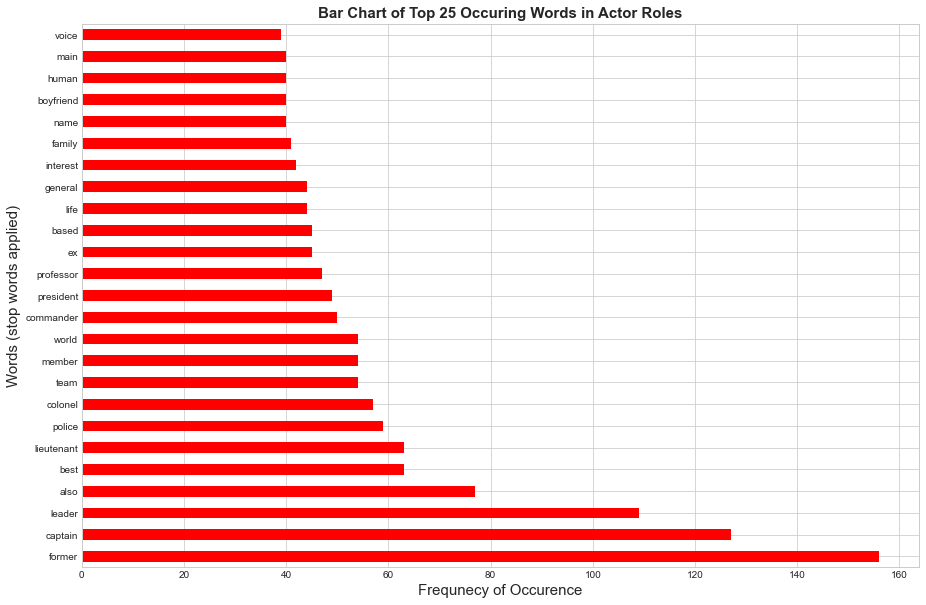

In [35]:
c_vectorizer = CountVectorizer(min_df=5,stop_words=stopwords)
# Instantiate Countvectorizer ensuring that a word must occur in at least two documents
# And that standard stop words are omitted
X_temp_pr = df[df['category'] == 'actor']['role'].copy()
X_temp_pr.reset_index(drop=True, inplace = True)
c_vectorizer.fit(X_temp_pr) # Fit
X_binary_temp_pr = c_vectorizer.transform(X_temp_pr) # Transform X to binary
# remember to use .todense() to de-sparsify the count vectorized text
X_binary_temp_dense_pr = pd.DataFrame(X_binary_temp_pr.todense(), columns=c_vectorizer.get_feature_names())

# plot top occuring words
plt.figure(figsize=(15,10))
plt.xlabel("Frequnecy of Occurence",fontsize=15)
plt.ylabel("Words (stop words applied)",fontsize=15)
plt.title ("Bar Chart of Top 25 Occuring Words in Actor Roles",fontsize=15, y=1, fontweight='bold', x=0.5)
X_binary_temp_dense_pr.sum().sort_values(ascending=False).head(25).plot(kind='barh', color = 'red'); # Show top 10 words as a bar chart

## 5.2 Identify Top Occuring Words in Roles played by Female Characters

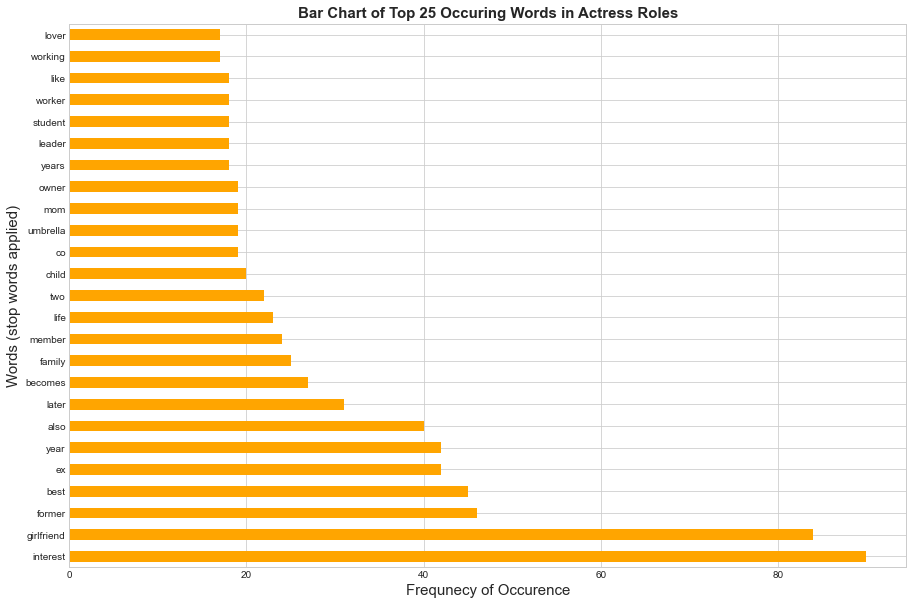

In [36]:
c_vectorizer = CountVectorizer(min_df=5,stop_words=stopwords)
# Instantiate Countvectorizer ensuring that a word must occur in at least two documents
# And that standard stop words are omitted
X_temp_pr = df[df['category'] == 'actress']['role'].copy()
X_temp_pr.reset_index(drop=True, inplace = True)
c_vectorizer.fit(X_temp_pr) # Fit
X_binary_temp_pr = c_vectorizer.transform(X_temp_pr) # Transform X to binary
# remember to use .todense() to de-sparsify the count vectorized text
X_binary_temp_dense_pr = pd.DataFrame(X_binary_temp_pr.todense(), columns=c_vectorizer.get_feature_names())

# plot top occuring words
plt.figure(figsize=(15,10))
plt.xlabel("Frequnecy of Occurence",fontsize=15)
plt.ylabel("Words (stop words applied)",fontsize=15)
plt.title ("Bar Chart of Top 25 Occuring Words in Actress Roles",fontsize=15, y=1, fontweight='bold', x=0.5)
X_binary_temp_dense_pr.sum().sort_values(ascending=False).head(25).plot(kind='barh', color = 'orange'); # Show top 10 words as a bar chart

## 5.3 Identify Top Occuring Trigrams in Roles played by Male Characters

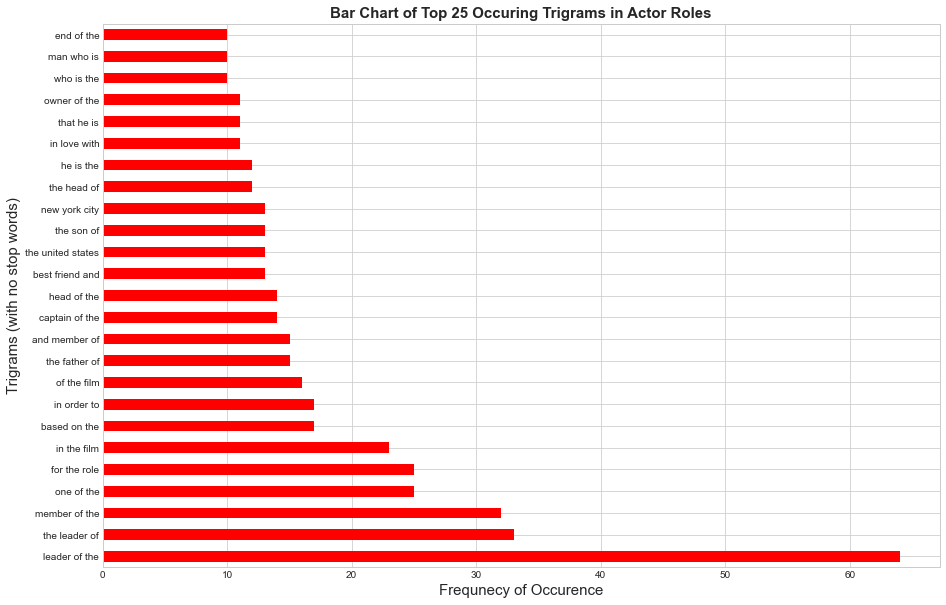

In [37]:
c_vectorizer = CountVectorizer(ngram_range=(3,3),min_df=5)
# Instantiate Countvectorizer ensuring that a word must occur in at least two documents
# And that standard stop words are omitted
X_temp_pr = df[df['category'] == 'actor']['role'].copy()
X_temp_pr.reset_index(drop=True, inplace = True)
c_vectorizer.fit(X_temp_pr) # Fit
X_binary_temp_pr = c_vectorizer.transform(X_temp_pr) # Transform X to binary
# remember to use .todense() to de-sparsify the count vectorized text
X_binary_temp_dense_pr = pd.DataFrame(X_binary_temp_pr.todense(), columns=c_vectorizer.get_feature_names())

# plot top occuring words
plt.figure(figsize=(15,10))
plt.xlabel("Frequnecy of Occurence",fontsize=15)
plt.ylabel("Trigrams (with no stop words)",fontsize=15)
plt.title ("Bar Chart of Top 25 Occuring Trigrams in Actor Roles",fontsize=15, y=1, fontweight='bold', x=0.5)
X_binary_temp_dense_pr.sum().sort_values(ascending=False).head(25).plot(kind='barh', color = 'red'); # Show top 10 words as a bar chart

## 5.4 Identify Top Occuring Trigrams in Roles played by Female Characters

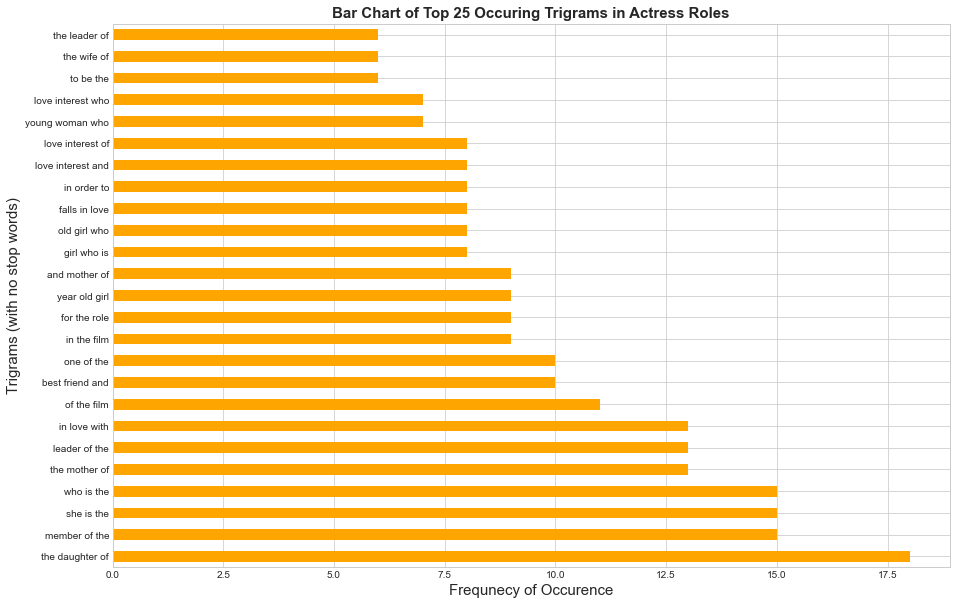

In [38]:
c_vectorizer = CountVectorizer(ngram_range=(3,3),min_df=5)
# Instantiate Countvectorizer ensuring that a word must occur in at least two documents
# And that standard stop words are omitted
X_temp_pr = df[df['category'] == 'actress']['role'].copy()
X_temp_pr.reset_index(drop=True, inplace = True)
c_vectorizer.fit(X_temp_pr) # Fit
X_binary_temp_pr = c_vectorizer.transform(X_temp_pr) # Transform X to binary
# remember to use .todense() to de-sparsify the count vectorized text
X_binary_temp_dense_pr = pd.DataFrame(X_binary_temp_pr.todense(), columns=c_vectorizer.get_feature_names())

# plot top occuring words
plt.figure(figsize=(15,10))
plt.xlabel("Frequnecy of Occurence",fontsize=15)
plt.ylabel("Trigrams (with no stop words)",fontsize=15)
plt.title ("Bar Chart of Top 25 Occuring Trigrams in Actress Roles",fontsize=15, y=1, fontweight='bold', x=0.5)
X_binary_temp_dense_pr.sum().sort_values(ascending=False).head(25).plot(kind='barh', color = 'orange'); # Show top 10 words as a bar chart

# 6.0 Unsupervised Learning with LDA

**NOTE:** Code here is largely modified from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0 and is not my own.

## 6.1 Text Processing

In [39]:
# Remove punctuation
df['role_processed'] = \
df['role'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['role_processed'] = \
df['role_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df['role_processed'].head()

0      amelia cranston
1              sin-dee
2    natalie van miter
3      anne-marie cole
4        adam steiffel
Name: role_processed, dtype: object

## 6.2 Word Cloud Analysis of Processed Text

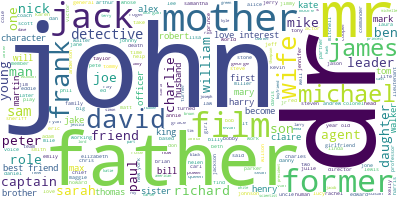

In [40]:
# Join the different processed titles together.
long_string = ','.join(list(df['role_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## 6.3 Removal of StopWords

In [41]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stopwords] for doc in texts]


data = df['role_processed'].values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['amelia']


## 6.4 Create Dictionary and Word Corpus

In [42]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

## 6.5 Display The selected Topics

In [43]:
# number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"best" + 0.006*"year" + 0.005*"also" + 0.004*"family" + '
  '0.004*"police" + 0.004*"captain" + 0.004*"working" + 0.004*"colonel" + '
  '0.003*"lord" + 0.003*"general"'),
 (1,
  '0.009*"interest" + 0.008*"leader" + 0.006*"girlfriend" + 0.005*"member" + '
  '0.005*"former" + 0.004*"name" + 0.004*"later" + 0.004*"president" + '
  '0.004*"team" + 0.004*"lieutenant"'),
 (2,
  '0.011*"former" + 0.006*"captain" + 0.006*"life" + 0.006*"interest" + '
  '0.005*"ex" + 0.005*"boyfriend" + 0.004*"best" + 0.004*"commander" + '
  '0.004*"girlfriend" + 0.003*"voice"')]


## 6.6 Compute Coherence Score

In [44]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6074809955705484


## 6.7 Assign Topics to Individual Documents

In [45]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [46]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.00000,0.66130,"best, year, also, family, police, captain, wor...",[amelia]
1,1,0.00000,0.65700,"best, year, also, family, police, captain, wor...",[sin]
2,2,0.00000,0.33330,"best, year, also, family, police, captain, wor...",[]
3,3,0.00000,0.33330,"best, year, also, family, police, captain, wor...",[]
4,4,0.00000,0.33330,"best, year, also, family, police, captain, wor...",[]
5,5,1.00000,0.95430,"interest, leader, girlfriend, member, former, ...","[proprietor, gourmet, club, running, gag, peop..."
6,6,0.00000,0.33330,"best, year, also, family, police, captain, wor...",[]
7,7,0.00000,0.33330,"best, year, also, family, police, captain, wor...",[]
8,8,1.00000,0.79220,"interest, leader, girlfriend, member, former, ...","[scientist, created, folk]"
9,9,0.00000,0.33330,"best, year, also, family, police, captain, wor...",[]


In [47]:
df_dominant_topic['category'] = df['category']
df_dominant_topic['role'] = df['role']

In [48]:
df_dominant_topic[df_dominant_topic['Text'].map(lambda d: len(d)) >= 2].head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,category,role
5,5,1.00000,0.95430,"interest, leader, girlfriend, member, former, ...","[proprietor, gourmet, club, running, gag, peop...",actor,"Carmine Sabatini, the proprietor of the Gourme..."
8,8,1.00000,0.79220,"interest, leader, girlfriend, member, former, ...","[scientist, created, folk]",actor,"Dr. Moreau, a mad scientist who created the Be..."
42,42,1.00000,0.76180,"interest, leader, girlfriend, member, former, ...","[sir, voiced]",actor,Sir Charles Litton (voiced by Rich Little)
58,58,2.00000,0.54470,"former, captain, life, interest, ex, boyfriend...","[cat, waul]",actor,Cat R. Waul
61,61,0.00000,0.93270,"best, year, also, family, police, captain, wor...","[world, police, department, intent, catching, ...",actor,"Detective Frank Harris, a detective for the Co..."
64,64,1.00000,0.90460,"interest, leader, girlfriend, member, former, ...","[soap, salesman, narrator, meets, business, tr...",actor,"Tyler Durden, a soap salesman that the Narrato..."
68,68,0.00000,0.96020,"best, year, also, family, police, captain, wor...","[metro, former, nemesis, would, rather, pursue...",actor,"Metro Man, Megaminds former nemesis who would ..."
69,69,2.00000,0.75980,"former, captain, life, interest, ex, boyfriend...","[tank, commander]",actor,"First Sergeant Don ""Wardaddy"" Collier, tank co..."
70,70,2.00000,0.77460,"former, captain, life, interest, ex, boyfriend...","[wing, commander]",actor,Wing Commander Max Vatan
81,81,0.00000,0.82390,"best, year, also, family, police, captain, wor...","[florist, begins, dating]",actress,"Eloise Chandler, a florist and the woman that ..."


## 6.7 LDA Modelling

In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()

In [50]:
LDAvis_data_filepath = os.path.join('/Users/macbook/Google Drive/0. Ofilispeaks Business (Mac and Cloud)/9. Data Science/0. Python/General Assembly Training/Project 6/data/LDA_'+str(num_topics))
# # this is a bit time consuming - make the if statement True

# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/Users/macbook/Google Drive/0. Ofilispeaks Business (Mac and Cloud)/9. Data Science/0. Python/General Assembly Training/Project 6/data/LDA_'+ str(num_topics) +'.html')
LDAvis_prepared

# reference https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

PreparedData(topic_coordinates=             x        y  topics  cluster     Freq
topic                                            
2      0.00279 -0.07335       1        1 34.64695
1     -0.06936  0.03442       2        1 33.85509
0      0.06658  0.03893       3        1 31.49796, topic_info=          Term     Freq     Total Category  logprob  loglift
500       life 60.00000  60.00000  Default 30.00000 30.00000
204     leader 96.00000  96.00000  Default 29.00000 29.00000
26   president 34.00000  34.00000  Default 28.00000 28.00000
128  boyfriend 51.00000  51.00000  Default 27.00000 27.00000
84          ex 74.00000  74.00000  Default 26.00000 26.00000
..         ...      ...       ...      ...      ...      ...
117      human 13.47705  39.48424   Topic3 -6.32250  0.08030
138     member 15.34078  69.03857   Topic3 -6.19290 -0.34890
469      actor 11.77282  24.02728   Topic3 -6.45770  0.44190
204     leader 14.64570  96.80031   Topic3 -6.23930 -0.73330
147   interest 14.74150 132.68627   Topic3 -6.23280 -1.04210

[243 rows x 6 columns], token_table=      Topic    Freq       Term
term                          
369       1 0.68422  abilities
369       2 0.15790  abilities
369       3 0.15790  abilities
469       1 0.20810      actor
469       2 0.29134      actor
...     ...     ...        ...
416       2 0.13232       year
416       3 0.54131       year
366       1 0.56318      years
366       2 0.15360      years
366       3 0.28159      years

[418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

# 7.0 Supervised Learning

## 7.1 Logistic Regression Model with Count Vectorizer (without StopWords applied)

In [51]:
# Creating Testing and Validation Datasets for Binarized Words
X = df['role'].copy()
y = df['category'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [52]:
start_time = time.time()
pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english')),
    ('lr', LogisticRegressionCV(solver='liblinear', max_iter=1000))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)
log_time = (time.time() - start_time)
print (f'''This took {log_time} second to run
With train accuracy score of [{round(100*pipe.score(X_train, y_train))}]%
and testing accuracy score of [{round(100*pipe.score(X_test, y_test))}]%''')

This took 3.7856409549713135 second to run
With train accuracy score of [98]%
and testing accuracy score of [89]%


In [53]:
confusion_matrix(y_test, pipe.predict(X_test))

array([[3191,  117],
       [ 448, 1557]])

## 7.2 Logistic Regression Model with Count Vectorizer (with StopWords applied)

In [54]:
start_time = time.time()
pipe = Pipeline([
    ('cv', CountVectorizer(stop_words=stopwords)),
    ('lr', LogisticRegressionCV(solver='liblinear', max_iter=1000))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)
log_time = (time.time() - start_time)
print (f'''This took {log_time} second to run
With train accuracy score of [{round(100*pipe.score(X_train, y_train))}]%
and testing accuracy score of [{round(100*pipe.score(X_test, y_test))}]%''')

This took 2.431450843811035 second to run
With train accuracy score of [66]%
and testing accuracy score of [63]%


In [55]:
confusion_matrix(y_test, pipe.predict(X_test))

array([[3267,   41],
       [1899,  106]])

In [56]:
coeffs = pipe.named_steps['lr'].coef_
words = pipe.named_steps['cv'].get_feature_names()
pd.DataFrame(coeffs.T, index=[words], columns=['Coefficient']).sort_values(by='Coefficient', ascending=False).head(10)

,Coefficient
girlfriend,2.23962
heather,1.30100
mom,1.19398
interest,1.09870
widow,1.09483
stepmother,0.98712
amelia,0.92364
niece,0.87906
teresa,0.86442
mama,0.85297


In [57]:
coeffs = pipe.named_steps['lr'].coef_
words = pipe.named_steps['cv'].get_feature_names()
pd.DataFrame(coeffs.T, index=[words], columns=['Coefficient']).sort_values(by='Coefficient', ascending=True).head(10)

,Coefficient
president,-1.37515
captain,-1.36390
boyfriend,-1.04005
police,-1.01992
inspector,-0.94453
commander,-0.92416
colonel,-0.88670
leader,-0.82913
professor,-0.78855
santa,-0.77225


## 7.4 XGBoost Classifier Model Run on Numerical and Dummified Data Sets

In [58]:
# Dummify Genre Column
df_temp = df['genre'].str.split(',').str.join('|').str.get_dummies()

In [59]:
# Concat DataFrames above
df_full = pd.concat ([df_temp,df], axis =1).reset_index()

In [60]:
# We notice that some of the Columns have spaces, so we have to merge them
df_full.columns

Index(['index', ' Action', ' Adventure', ' Animation', ' Biography', ' Comedy',
       ' Crime', ' Drama', ' Family', ' Fantasy', ' History', ' Horror',
       ' Music', ' Musical', ' Mystery', ' Romance', ' Sci-Fi', ' Sport',
       ' Thriller', ' War', ' Western', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'Western', 'imdb_title_id', 'original_title_x', 'imdb_name_id',
       'name_x', 'height', 'date_of_birth', 'place_of_birth', 'spouses',
       'divorces', 'children', 'year', 'genre', 'duration', 'country',
       'production_company', 'avg_vote', 'budget', 'usa_gross_income',
       'worlwide_gross_income', 'metascore', 'reviews_from_users',
       'reviews_from_critics', 'ordering', 'category', 'role',
       'age_at_release', 'roi', 'year_date', 'stopwords', 'role_processed'],
      dtype='object')

In [61]:
# Merging of the Columns
df_full['Action'] = df_full[' Action'] + df_full['Action']
df_full['Adventure'] = df_full[' Adventure'] + df_full['Adventure']
df_full['Animation'] = df_full[' Animation'] + df_full['Animation']
df_full['Biography'] = df_full[' Biography'] + df_full['Biography']
df_full['Comedy'] = df_full[' Comedy'] + df_full['Comedy']
df_full['Crime'] = df_full[' Crime'] + df_full['Crime']
df_full['Drama'] = df_full[' Drama'] + df_full['Drama']
df_full['Family'] = df_full[' Family'] + df_full['Family']
df_full['Fantasy'] = df_full[' Fantasy'] + df_full['Fantasy']
#df_full['History'] = df_full[' History'] + df_full['History']
df_full['Horror'] = df_full[' Horror'] + df_full['Horror']
df_full['Music'] = df_full[' Music'] + df_full['Music']
df_full['Musical'] = df_full[' Musical'] + df_full['Musical']
df_full['Mystery'] = df_full[' Mystery'] + df_full['Mystery']
df_full['Romance'] = df_full[' Romance'] + df_full['Romance']
df_full['Sci-Fi'] = df_full[' Sci-Fi'] + df_full['Sci-Fi']
df_full['Sport'] = df_full[' Sport'] + df_full['Sport']
df_full['Thriller'] = df_full[' Thriller'] + df_full['Thriller']
#df_full['War'] = df_full[' War'] + df_full['War']
df_full['Western'] = df_full[' Western'] + df_full['Western']

In [62]:
# Delete Uneeded Columns
del df_full ['index']
del df_full ['stopwords']
del df_full ['role']
del df_full ['year_date']
del df_full ['roi']
del df_full ['imdb_title_id']
del df_full ['original_title_x']
del df_full ['imdb_name_id']
del df_full ['name_x']
del df_full ['height']
del df_full ['date_of_birth']
del df_full ['place_of_birth']
del df_full ['country']
del df_full ['genre']
del df_full ['production_company']
del df_full ['budget']
del df_full ['usa_gross_income']
del df_full ['worlwide_gross_income']
del df_full ['metascore']
del df_full ['reviews_from_users']
del df_full ['reviews_from_critics']
del df_full ['age_at_release']
del df_full['role_processed']

del df_full[' Action']
del df_full[' Adventure']
del df_full[' Animation']
del df_full[' Biography']
del df_full[' Comedy']
del df_full[' Crime']
del df_full[' Drama']
del df_full[' Family']
del df_full[' Fantasy']
del df_full[' History']
del df_full[' Horror']
del df_full[' Music']
del df_full[' Musical']
del df_full[' Mystery']
del df_full[' Romance']
del df_full[' Sci-Fi']
del df_full[' Sport']
del df_full[' Thriller']
del df_full[' War']
del df_full[' Western']

In [63]:
# Reset FInal DataFrame
df_full.reset_index(drop=True, inplace=True)

In [64]:
# Due to repeated actors and actresses in multiple roles, we would only seek to identify the Leads
df_full = df_full[df_full['ordering']==1]

In [65]:
# Value count of the Category Feature in DataSet
df_full.category.value_counts()

actor      4052
actress    1756
Name: category, dtype: int64

In [66]:
X_full = df_full.drop(columns = 'category')
y_full = df_full['category'].copy()

X_trains, X_tests, y_trains, y_tests = train_test_split(X_full, y_full, random_state=42, stratify=y_full)

In [67]:
start_time = time.time()

xboost = XGBClassifier()

xboost.fit(X_trains, y_trains)
xboost.score(X_trains, y_trains), xboost.score(X_tests, y_tests)
log_time = (time.time() - start_time)
print (f'''This took {log_time} second to run
With train accuracy score of [{round(100*xboost.score(X_trains, y_trains))}]%
and testing accuracy score of [{round(100*xboost.score(X_tests, y_tests))}]%''')

[16:36:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This took 0.7013461589813232 second to run
With train accuracy score of [92]%
and testing accuracy score of [70]%


In [68]:
confusion_matrix(y_tests, xboost.predict(X_tests))

array([[845, 168],
       [271, 168]])

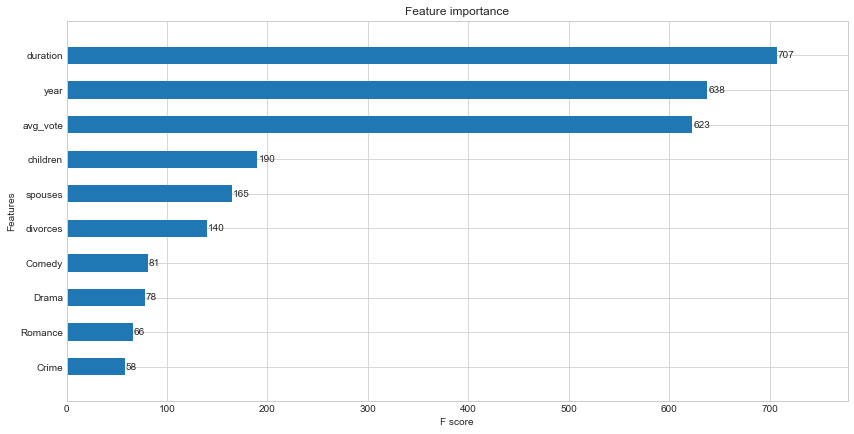

In [69]:
# plot feature importance
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(xboost, max_num_features=10, height = 0.5);
# Reference https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/